# Create Project

In [1]:
#import libraries 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Stats materials
from scipy import stats
import scipy.stats as stats

# import SQL materials
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists
import pymysql
pymysql.install_as_MySQLdb()
from urllib.parse import quote_plus as urlquote
from sqlalchemy_utils import create_database, database_exists

In [18]:
# import the data
filename = 'Data4/tmdb_results_combined.csv.gz'
firsthypo_df=pd.read_csv(filename)
#check that the data loaded
firsthypo_df.head(2)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN


In [19]:
#check info
firsthypo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547 entries, 0 to 2546
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                2547 non-null   object 
 1   adult                  2545 non-null   float64
 2   backdrop_path          1374 non-null   object 
 3   belongs_to_collection  204 non-null    object 
 4   budget                 2545 non-null   float64
 5   genres                 2545 non-null   object 
 6   homepage               172 non-null    object 
 7   id                     2545 non-null   float64
 8   original_language      2545 non-null   object 
 9   original_title         2545 non-null   object 
 10  overview               2494 non-null   object 
 11  popularity             2545 non-null   float64
 12  poster_path            2288 non-null   object 
 13  production_companies   2545 non-null   object 
 14  production_countries   2545 non-null   object 
 15  rele

# Preparing Data

In [20]:
# check the value counts on certification column for first hypothesis
firsthypo_df['certification'].value_counts()


R          459
PG-13      183
NR          73
PG          62
G           24
NC-17        6
Unrated      1
-            1
Name: certification, dtype: int64

In [21]:
# explore the  missing data
num_missing = firsthypo_df['certification'].isna().sum()

total_rows = firsthypo_df.shape[0]

percent_missing = num_missing / total_rows
print(f'{percent_missing:.2f}% of the data in the certification column is missing')

0.68% of the data in the certification column is missing


In [22]:
# find the row with - rating
firsthypo_df.loc[firsthypo_df['certification'] == '-']

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
2057,tt0282526,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,172550.0,it,Giorni,...,0.0,90.0,"[{'english_name': 'Italian', 'iso_639_1': 'it'...",Released,NaN,Days,0.0,5.4,8.0,-


In [23]:
#  drop the row, it has 0 revenue
#firsthypo_df=firsthypo_df.dropna(firsthypo_df['certification']==['-'], inplace=True)
#firsthypo_df.drop(2056)
firsthypo_df = firsthypo_df.loc[firsthypo_df['certification'] != '-']

In [24]:
# check the value counts on certification column for first hypothesis
firsthypo_df['certification'].value_counts()


R          459
PG-13      183
NR          73
PG          62
G           24
NC-17        6
Unrated      1
Name: certification, dtype: int64

In [25]:
# drop the unrated column
firsthypo_df = firsthypo_df.loc[firsthypo_df['certification'] != 'Unrated']

In [26]:
# drop NC 17 column
firsthypo_df = firsthypo_df.loc[firsthypo_df['certification'] != 'NC-17']
firsthypo_df['certification'].value_counts()


R        459
PG-13    183
NR        73
PG        62
G         24
Name: certification, dtype: int64

In [30]:
#drop null values in certification column
firsthypo_df = firsthypo_df.dropna(subset=['certification'])

# First Hypothesis

## Hypothesis
- Null: Movies have the same revenue in all MPAA ratings
- Alternate: Movies with different MPAA ratings  have different revenue.

- Possible question would me how much? See Project 5 for linear regression

## Test type: ANOVA

In [31]:
## Create groups dictionary. 
groups = {}
## Loop through all unique categories
for i in firsthypo_df['certification'].unique():
    ## Get series for group and rename
    data = firsthypo_df.loc[firsthypo_df['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['PG', 'R', 'G', 'NR', 'PG-13'])

## Check Assumptions for ANOVA
- outliers
- normality
- equal variance

In [32]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
PG,62.0,1.166369e-19,87.190443
R,459.0,4.064768e-104,476.132986
G,24.0,1.196858e-08,36.481962
NR,73.0,6.755199e-21,92.887949
PG-13,183.0,7.619494e-31,138.698856


- This data has normal distribution

In [33]:
# check for equal variance
stats.levene(*groups.values())

LeveneResult(statistic=19.784484478760714, pvalue=1.5312390633583929e-15)

- This data group passed the equal variance, so ANOVA can be used

## Check for Outliers

In [37]:
#create groups
pg_df = firsthypo_df.loc[firsthypo_df['certification']== 'PG'].copy()
r_df = firsthypo_df.loc[firsthypo_df['certification']== 'R'].copy()
g_df = firsthypo_df.loc[firsthypo_df['certification']== 'G'].copy()
nr_df = firsthypo_df.loc[firsthypo_df['certification']== 'NR'].copy()
pg13_df = firsthypo_df.loc[firsthypo_df['certification']== 'PG-13'].copy()

# groups PG', 'R', 'G', 'NR', 'PG-13'

In [38]:
#create each specific group for outlier check
pg_df_revenue = pg_df['revenue']
r_df_revenue = r_df['revenue']
g_df_revenue = g_df['revenue']
nr_df_revenue = nr_df['revenue']
pg13_df_revenue = pg13_df['revenue']


In [39]:
# Check for outliers in pg group
zscores= stats.zscore(pg_df_revenue)
outliers = abs(zscores)>3
np.sum(outliers)

1

In [40]:
# drop outlier
pg_df_revenue = pg_df_revenue[(np.abs(stats.zscore(pg_df_revenue)) < 3)]

In [41]:
# Check for outliers in r group
zscores= stats.zscore(r_df_revenue)
outliers = abs(zscores)>3
np.sum(outliers)

12

In [42]:
# drop outlier
r_df_revenue = r_df_revenue[(np.abs(stats.zscore(r_df_revenue)) < 3)]

In [43]:
# Check for outliers in g group
zscores= stats.zscore(g_df_revenue)
outliers = abs(zscores)>3
np.sum(outliers)

1

In [45]:
# drop outlier
g_df_revenue = g_df_revenue[(np.abs(stats.zscore(g_df_revenue)) < 3)]

In [46]:
# Check for outliers in nr group
zscores= stats.zscore(nr_df_revenue)
outliers = abs(zscores)>3
np.sum(outliers)

3

In [47]:
# drop outliers
nr_df_revenue = nr_df_revenue[(np.abs(stats.zscore(nr_df_revenue)) < 3)]

In [48]:
# Check for outliers in pg13 group
zscores= stats.zscore(pg13_df_revenue)
outliers = abs(zscores)>3
np.sum(outliers)

5

In [50]:
# drop outlier
pg13_df_revenue = pg13_df_revenue[(np.abs(stats.zscore(pg13_df_revenue)) < 3)]

In [53]:
#groups2= (pg_df_revenue, r_df_revenue, g_df_revenue, nr_df_revenue, pg13_df_revenue)

## Run anova

In [59]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.f_oneway( *groups.values())
print(result)
pg_df_revenue, r_df_revenue, g_df_revenue, nr_df_revenue, pg13_df_revenue

F_onewayResult(statistic=19.564570435507452, pvalue=2.2624257518793202e-15)


True

## Interpretation

### The p value is less 0.05. From this data the null hypothesis is rejected. There is a difference between revenue in the different MPAA ratings

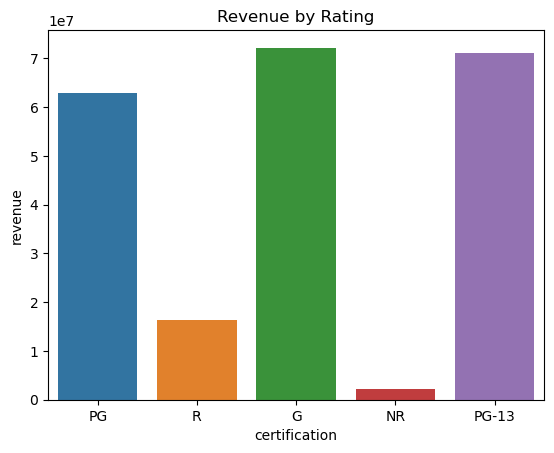

In [63]:
#visualize the data
ax= sns.barplot(data=firsthypo_df, x='certification',y='revenue', errorbar=None);
ax.set_title("Revenue by Rating");

- Movies with a G rating have the greatest revenue followed  closely by movies with a PG-13 rating. 

# Second Hypothesis